In [ ]:
import flwr as fl 
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt




In [7]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [8]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [9]:
test = pd.read_csv('../test_glob.csv')

In [10]:
X_train, y_train = data_1.drop(columns=["Fraud"]), data_1["Fraud"]
X_train_2, y_train_2 = data_2.drop(columns=["Fraud"]), data_2["Fraud"]


X_train_scale = scaler.fit_transform(X_train)
X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)

X_train_scale_2 = scaler.fit_transform(X_train_2)
X_train_2, y_train_2 = smote.fit_resample(X_train_scale_2, y_train_2)


X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [44]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()





In [ ]:
class CustomClientDP(fl.client.NumPyClient):
    # Инициализируем списки для хранения потерь и метрик
    def __init__(self):
        super().__init__()
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)
        return params

    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        print('============================ PARAMS BEFORE FIT ===========================')
        print(parameters)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_, y_train_)
        
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        # Возвращаем параметры модели после обучения
        return params_1, len(X_train_2), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        
        # Вычисляем метрики
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        # Сохраняем метрики в списки
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        # Возвращаем значения для сервера
        return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        penalty='l2',
        max_iter=10
    )

    ts.set_initial_parameters(model)
    
    # Создаем клиента
    client_dp = CustomClientDP()

    # Запускаем клиента
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )

INFO :      
INFO :      Received: get_parameters message c3eccfd1-e06e-4595-8185-122c273a5c61
INFO :      Sent reply


================== INITIAL PARAMS ==================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]


INFO :      
INFO :      Received: train message 6a9b0f9b-ce8c-4643-9dbd-f036a4c927bc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 535c03ba-7ac7-4f74-b5ed-676f8497a30b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 23982936-9218-45d5-b4a5-26f7ced539e2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fe50822b-40dd-4d72-9c5e-1e94c57f5c97
INFO :      Sent reply
INFO :      
INFO :      Received: train message bcd4f9a2-c8d2-47c4-b33e-b97e4f2d2f8a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 593ddd11-63e7-4272-9a39-59d63fe66d59
INFO :      Sent reply
INFO :      
INFO :      Received: train message a86b2956-d845-4fcc-82a3-4ffdaa4c3e77


============================ PARAMS BEFORE FIT ===========================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01,
        -4.78846972e-02, -5.30664493e-02,  4.64005691e-02,
         7.12553314e-02,  3.94535626e-02,  6.24732089e-02,
        -2.36745902e-01, -2.52817277e-02, -7.50333392e-02,
        -2.34070236e-02, -5.06478361e-02, -1.41600188e-01,
        -1.67979732e-02,  5.50181624e-04, -9.70984037e-02,
        -8.93824113e-01,  0.00000000e+00,

INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c5c5f731-bd0b-4375-bc52-a3d28303a8ae
INFO :      Sent reply
INFO :      
INFO :      Received: train message fea0531a-934b-4bd0-8c8f-eb752e6b0051
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 29d5871d-16f5-4518-bca7-957866c47e70
INFO :      Sent reply
INFO :      
INFO :      Received: train message 327941f2-a2f5-4d53-9193-568d5279c41e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 92a7a685-1388-435a-8759-dde0e33e2cc0
INFO :      Sent reply


Training finished for round 4
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01,
        -4.78846972e-02, -5.30664493e-02,  4.64005691e-02,
         7.12553314e-02,  3.94535626e-02,  6.24732089e-02,
        -2.36745902e-01, -2.52817277e-02, -7.50333392e-02,
        -2.34070236e-02, -5.06478361e-02, -1.41600188e-01,
        -1.67979732e-02,  5.50181624e-04, -9.70984037e-02,
        -8.93824113e-01,  0.00000000e+00,  1.16246760e-01]]), array([0.06907481])]
========================== evaluate PARAMS =============================================
accuracy: 0.875810635538262
ROC_AUC: 0.7590909090909091
f1_score: 0.20041753653444677
============================ PA

INFO :      
INFO :      Received: train message b51d3e03-04db-4b8f-8c4d-0c1832798ee5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 611e7880-7e1b-44b2-ad2d-eadcae05d97a
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8ffac31b-9dae-455e-a20f-fc50861fc718
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 298a12c2-fd35-4ac1-8933-24316cb3e84d
INFO :      Sent reply
INFO :      
INFO :      Received: train message dae25381-7442-4924-9a31-169c545cbe26
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d5d20f2f-6ca9-4ca8-846f-b4e0135df4aa
INFO :      Sent reply
INFO :      
INFO :      Received: train message 42054de5-dd04-402a-abcf-bfb84728a84d
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00862189, -0.02776012, -0.01418135, -0.0153341 ,  0.00549387,
         0.03120815, -0.00919881, -0.02567248,  0.08384086, -0.00252172,
        -0.01738532, -0.29127835, -0.03193107, -0.12459984,  0.08329552,
        -0.03035413,  0.01946067, -0.00699063,  0.01019631,  0.01996728,
         0.00379571, -0.10067119, -0.04801898, -0.02097482,  0.02097319,
        -0.01868182, -0.04865394,  0.00311669, -0.01437963, -0.03194627,
        -0.29884655, -0.00824177,  0.03409111]]), array([0.02823194])]
Training finished for round 7
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01,

INFO :      
INFO :      Received: evaluate message 1a3f1422-01e1-40b2-899f-278e8aaf6f22
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8804e472-55fe-4331-a29f-a14628451a45
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a497f43c-8bb8-4c2e-8c19-350595fb48ab
INFO :      Sent reply
INFO :      
INFO :      Received: train message b158d5c9-cfe3-4f23-ab3e-8cd57e44559e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d54e6714-c81c-4f87-963a-e599ec16e0ad
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5232ff17-3c03-426d-b753-f7fd9f5be45e
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8553826199740596
ROC_AUC: 0.761283287419651
f1_score: 0.22569444444444445
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01503577, -0.02928041, -0.02531821, -0.03427929,  0.00534149,
         0.03766409, -0.01012399, -0.02475198,  0.12720803, -0.00518381,
        -0.037496  , -0.40365038, -0.03496344, -0.19105329,  0.09111046,
        -0.03905658,  0.03323229, -0.01697843,  0.02906969,  0.01636467,
         0.00840486, -0.14170475, -0.05122918, -0.0364612 ,  0.01073893,
        -0.03320382, -0.08598008, -0.00982797, -0.02231858, -0.06284704,
        -0.42535951, -0.00897446,  0.05413315]]), array([0.05148928])]
Training finished for round 11
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,


INFO :      Received: evaluate message 5f0e2601-cc96-4860-b22d-d039f88750ec
INFO :      Sent reply
INFO :      
INFO :      Received: train message 92b281f5-97b6-4d7a-bfa6-a9939708ec99
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9164ac39-f7a0-4029-a4bc-189dbbb565d5
INFO :      Sent reply
INFO :      
INFO :      Received: train message a718a31b-4b82-4bbf-baaf-f7a7a9627dfe
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ac030bd4-b507-4700-9b73-c36e3321df2b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3dcdb9b4-c566-4334-82a9-3765d1d731a4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 00711fac-643c-4795-82f7-8ec3fb24daf0
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8394941634241245
ROC_AUC: 0.7606137128864401
f1_score: 0.22291993720565148
============================ PARAMS BEFORE FIT ===========================
[array([[-9.71384302e-03, -3.27284613e-02, -2.48587125e-02,
        -4.52276097e-02, -7.26482430e-03,  3.63999039e-02,
        -1.15044443e-02, -3.28833436e-02,  1.64072662e-01,
        -4.72034223e-03, -4.06035048e-02, -4.69569240e-01,
        -5.44471577e-02, -2.27512152e-01,  1.01006703e-01,
        -4.01325373e-02,  3.77908372e-02, -2.03317441e-02,
         4.02755806e-02,  2.42069619e-02,  2.88247861e-02,
        -1.70219320e-01, -5.47372559e-02, -3.35854867e-02,
        -1.11537303e-03, -4.13597153e-02, -1.04734771e-01,
         3.08771463e-04, -2.74596897e-02, -7.28999303e-02,
        -4.82829169e-01, -6.68124431e-03,  6.50782471e-02]]), array([0.05580362])]
Training finished for round 14
============================= PARAMETERS AFT

INFO :      Received: train message b59ca39b-bae2-476f-b8ae-a4792da4cdfa
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8b76f1e5-5aab-4923-8582-ad4d1a0e3d8b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5dfc388f-08e6-42a9-931f-a8680242dafd
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c88a95f4-acd3-42fd-8330-cc778833940c
INFO :      Sent reply
INFO :      
INFO :      Received: train message b3e71b8e-edc3-475f-a512-d17803f0e918
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7de02e08-b185-4682-bb44-82b6c0f2a382
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-0.01047065, -0.04061301, -0.03342149, -0.04702957, -0.00634434,
         0.04225289, -0.01443043, -0.030563  ,  0.1801609 , -0.00364898,
        -0.05033707, -0.51929395, -0.05629632, -0.25422027,  0.10745948,
        -0.03743607,  0.03930034, -0.02308933,  0.03825009,  0.03052538,
         0.0256948 , -0.18407312, -0.05007998, -0.02941766,  0.00621702,
        -0.0349091 , -0.11145596,  0.004605  , -0.02937135, -0.07424004,
        -0.53095905, -0.0032778 ,  0.06878774]]), array([0.04985461])]
Training finished for round 17
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01

INFO :      
INFO :      Received: train message 221457f1-10a9-4406-a7be-3774d694b335
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 830e00d4-bfe9-4faf-9506-0c5175ec44b3
INFO :      Sent reply
INFO :      
INFO :      Received: train message 341768b9-ab2c-493e-a813-145f7d83b2a8
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9be255f8-0ce8-4d2a-a7ba-8106c7f61347
INFO :      Sent reply
INFO :      
INFO :      Received: train message e733c8dc-799e-43f6-bc7c-d77a52b709a4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6ccf38af-3343-4331-96ca-c0dd9755aa67
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-5.07441158e-03, -4.45641810e-02, -3.66943827e-02,
        -5.58543670e-02, -8.06555186e-03,  4.55260746e-02,
        -1.11682776e-02, -3.19046000e-02,  1.99323435e-01,
         9.73353471e-05, -4.82426442e-02, -5.61538280e-01,
        -5.77006757e-02, -2.66902864e-01,  1.09050841e-01,
        -4.02287686e-02,  3.69674766e-02, -2.14387709e-02,
         4.43615181e-02,  3.05409217e-02,  2.33858696e-02,
        -1.98950043e-01, -4.91346687e-02, -4.21533631e-02,
         6.01821002e-03, -3.85400213e-02, -1.13130019e-01,
        -1.74281664e-04, -2.03880268e-02, -7.16556066e-02,
        -5.60817556e-01, -3.45698920e-04,  6.65003830e-02]]), array([0.05267014])]
Training finished for round 20
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.

INFO :      
INFO :      Received: train message 60cc2db2-7ca0-4c13-8efa-91ba84b8d9a4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 905a6889-360f-4385-b10a-43b5bbbc28a1
INFO :      Sent reply
INFO :      
INFO :      Received: train message eb832121-5a19-46e9-a537-5d229a058544
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 267c8f5d-20cc-4bbe-894e-5071baaa1af6
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5e59f686-5787-4e59-81e0-771ca4bd398f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c72aa7e9-2f58-4bd5-b476-793b3945ae11
INFO :      Sent reply
INFO :      
INFO :      Received: train message bca11b41-d93c-4a4f-a13d-52b3fd3dec1d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9484e97b-8b43-40cb-83b0-f91d843eea47
INFO :      Sent reply
INFO :      


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00755793, -0.04514846, -0.04172612, -0.05902917, -0.00454537,
         0.04673762, -0.01218289, -0.03419976,  0.21469028,  0.00247581,
        -0.04509063, -0.58980466, -0.05886046, -0.2784719 ,  0.11058527,
        -0.03857076,  0.03178826, -0.01411056,  0.04761004,  0.03220262,
         0.02604618, -0.2059745 , -0.05079894, -0.04412258,  0.00363963,
        -0.03484456, -0.11513574, -0.00424114, -0.01895775, -0.08018658,
        -0.58238318,  0.00378181,  0.06906945]]), array([0.05125749])]
Training finished for round 23
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01

INFO :      Received: train message 20c224d5-25ee-4795-a502-1a8c072962fd
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e0efcd68-0770-43ef-acac-456fb9153d78
INFO :      Sent reply
INFO :      
INFO :      Received: train message b6e004a3-43fa-493b-b182-52e2d88a0700
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ce6b554c-79af-4fa8-a124-507e503a4874
INFO :      Sent reply
INFO :      
INFO :      Received: train message 159175f5-a3af-4f7e-87f7-0472c2b4b67b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d48db1cc-75f0-45aa-b243-a3e03097ea4f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4bfd7c59-c450-4402-9dba-c8eb3c608604
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 75357b87-9024-4c0a-8cb2-db48892fdedc
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6fe59450-eb51-403d-ba8d-65e66b21dcd3
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00902349, -0.04779397, -0.04059299, -0.06043268, -0.00476453,
         0.04637639, -0.01383361, -0.03365876,  0.22250213,  0.0032467 ,
        -0.04295431, -0.61234892, -0.06370372, -0.29120266,  0.11601714,
        -0.04023012,  0.02816877, -0.00848915,  0.05011317,  0.03050958,
         0.02840372, -0.21398973, -0.05037277, -0.04553463,  0.00372029,
        -0.03730627, -0.11869175, -0.00249801, -0.01769978, -0.08417125,
        -0.60274581,  0.00445836,  0.07171792]]), array([0.04818085])]
Training finished for round 27
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01

INFO :      
INFO :      Received: evaluate message 2edb5a2a-aeb7-4705-bcb3-e386b882b501
INFO :      Sent reply
INFO :      
INFO :      Received: train message 596a6b15-7741-42db-a349-1c4ce2db399a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 5a6e3f58-8695-4c1a-82dc-1ef487b3142b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2a045c81-4c45-41c3-ae60-af03345bb18a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f378ae1c-1a1e-47f0-863e-46516ae72280
INFO :      Sent reply
INFO :      
INFO :      Received: train message 49534100-476d-4e12-91a5-d9405de526c6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message eeb9c709-68dc-4bac-8cad-9d10c80da863
INFO :      Sent reply
INFO :      
INFO :      Received: train message 00dd14e0-3fb3-4487-86d6-839b8fd0f300
INFO :      Sent reply


========================== evaluate PARAMS =============================================
accuracy: 0.8343060959792478
ROC_AUC: 0.7613311141720233
f1_score: 0.2198473282442748
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01093117, -0.05140096, -0.04116236, -0.06270564, -0.00378828,
         0.04825168, -0.01546179, -0.03275338,  0.2306127 ,  0.00269973,
        -0.04614785, -0.63093491, -0.06340642, -0.3011797 ,  0.11808667,
        -0.04046617,  0.02864578, -0.00416807,  0.05178036,  0.03163511,
         0.02983212, -0.21911294, -0.05072542, -0.04643598,  0.00327251,
        -0.03912082, -0.12558887, -0.00430477, -0.01718925, -0.08345668,
        -0.61861997,  0.00570899,  0.07630489]]), array([0.05033401])]
Training finished for round 32
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,


INFO :      
INFO :      Received: evaluate message 509fd913-ad5b-42f4-a476-f348c8921646
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7422b088-fb49-42da-9a24-34273574b5ea
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 92289ed7-df0a-461c-8f1e-d97a8eec165a
INFO :      Sent reply
INFO :      
INFO :      Received: train message aa0b2082-deb6-4867-a9eb-c0a2220e7546
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 88ddf8f6-e696-4f79-8cd9-814befabc9c2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8dcc45c9-e868-445d-ab54-e9905570793d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e28ceb7e-1b05-4032-9384-21dc1bfcd18f
INFO :      Sent reply
INFO :      
INFO :      Received: train message c00aae60-7431-48b7-8b50-b401bafb1bab
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6234d780-e437-42a3-b6ba-935becf32ea6
INFO :      Sent reply


========================== evaluate PARAMS =============================================
accuracy: 0.8300907911802854
ROC_AUC: 0.7614554637281911
f1_score: 0.21791044776119403
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01055195, -0.05388357, -0.0423642 , -0.06384347, -0.0041753 ,
         0.04876742, -0.01814312, -0.03132453,  0.23441984,  0.00348448,
        -0.04598709, -0.63998022, -0.06417932, -0.30591032,  0.11904442,
        -0.04066246,  0.02865179, -0.00317147,  0.05323809,  0.03323476,
         0.03266641, -0.22092039, -0.04912274, -0.0487486 ,  0.00311262,
        -0.0396275 , -0.12755501, -0.00546759, -0.01822701, -0.08496247,
        -0.62736157,  0.00488803,  0.0777037 ]]), array([0.05223915])]
Training finished for round 36
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,

INFO :      
INFO :      Received: train message 53906c21-7d3f-41d7-a31a-e1b52e228c2e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8f61817f-6286-4dfe-81fb-356cd2920437
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f03f559-b77a-45ea-94b2-4f664ab0c29d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f7e16438-0a69-4727-8229-843557441028
INFO :      Sent reply
INFO :      
INFO :      Received: train message a41efb6d-aded-46fb-8247-f8d4eddb86f7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message b2269488-03ab-4ef6-bd52-cdb3425c8b15
INFO :      Sent reply
INFO :      
INFO :      Received: train message 54c1093d-bcc4-4dfe-a995-9c74d8a91254
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bc12b85d-ae8d-4e5c-a386-d9ff8ecf948d
INFO :      Sent reply
INFO :      
INFO :      Received: train message a780134b-66db-473e-a6ec-920f674c7e6a
INFO :      Sent reply
INFO : 

============================ PARAMS BEFORE FIT ===========================
[array([[-0.01027103, -0.05445329, -0.04228097, -0.06453912, -0.00444074,
         0.04916399, -0.01783751, -0.03039984,  0.23662687,  0.00305067,
        -0.04619671, -0.64549106, -0.0646691 , -0.30892874,  0.12037145,
        -0.03997377,  0.02800099, -0.00252433,  0.05442383,  0.03406018,
         0.03343218, -0.22301995, -0.04904673, -0.04984888,  0.00293216,
        -0.03948221, -0.13029567, -0.00621381, -0.01744399, -0.08563772,
        -0.63283798,  0.00449396,  0.07836685]]), array([0.05293257])]
Training finished for round 40
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
        -2.12326032e-03, -4.82515087e-02,  3.26355256e-01,
        -9.49221329e-04, -4.32035876e-02, -9.47377551e-01,
        -1.33319288e-01, -4.46785686e-01,  1.57489080e-01

INFO :      Received: evaluate message 91db77be-3c60-4214-bde3-7190a824d1a2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 655b63c2-a6af-4832-889b-ed653a5d2f51
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 199e325a-fcdd-47b1-8009-7e7107e28853
INFO :      Sent reply
INFO :      
INFO :      Received: train message 24d2bd8c-eecb-4528-9e5d-abb8f7b64bc6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8ce79518-f263-4799-b28b-acdc1dbe251e
INFO :      Sent reply
INFO :      
INFO :      Received: train message eef02064-7f7d-427f-9db4-8c9a5e6a1d1d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f0f82852-4ad7-4616-963f-b389e83707d5
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9c87027e-8e0d-4bd0-bf6a-0a595e4e1781
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8287937743190662
ROC_AUC: 0.7614286807468625
f1_score: 0.2166172106824926
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01078712, -0.05497653, -0.04169562, -0.06511479, -0.00463377,
         0.04927624, -0.01774137, -0.03010379,  0.23899459,  0.00332766,
        -0.04653671, -0.64997838, -0.06502046, -0.31053912,  0.12109056,
        -0.04010426,  0.02853582, -0.00230966,  0.05497729,  0.03383976,
         0.03405731, -0.22463317, -0.04932591, -0.05007917,  0.00240641,
        -0.0393233 , -0.13089427, -0.00702943, -0.017239  , -0.08594822,
        -0.63709284,  0.00453341,  0.07856919]]), array([0.05367807])]
Training finished for round 45
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,


INFO :      Received: evaluate message 0f961280-1073-4f7e-8c45-a99e188e210f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 790d7fc6-adf9-4b4e-9f8d-3a17ab4318d7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 894bfe7b-0c61-4c55-bc1e-5987d09327ce
INFO :      Sent reply
INFO :      
INFO :      Received: train message f127b7e5-a3e2-4d2c-b0a7-708ef2104e03
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d83c2d9c-7017-4ab7-ac16-baf6541231e7
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8287937743190662
ROC_AUC: 0.761455463728191
f1_score: 0.2166172106824926
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01040481, -0.0551376 , -0.04121907, -0.06557364, -0.00430081,
         0.04955739, -0.01762989, -0.03003394,  0.23947239,  0.00307325,
        -0.04701299, -0.65206116, -0.06530405, -0.31160485,  0.12131838,
        -0.04031252,  0.02870623, -0.00207613,  0.05493998,  0.03392064,
         0.03433603, -0.22514343, -0.04942268, -0.05003842,  0.00174876,
        -0.03954351, -0.13157782, -0.00715645, -0.0170642 , -0.08638562,
        -0.63937793,  0.00445824,  0.07876865]]), array([0.05377502])]
Training finished for round 49
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-2.09664130e-02, -1.02599106e-01, -1.14101549e-02,
        -7.21024516e-02, -2.72944387e-03,  4.75313854e-06,
 

INFO :      Received: reconnect message e76ca3b4-1881-4900-bbbe-9a6dd6b8c553
INFO :      Disconnect and shut down


---

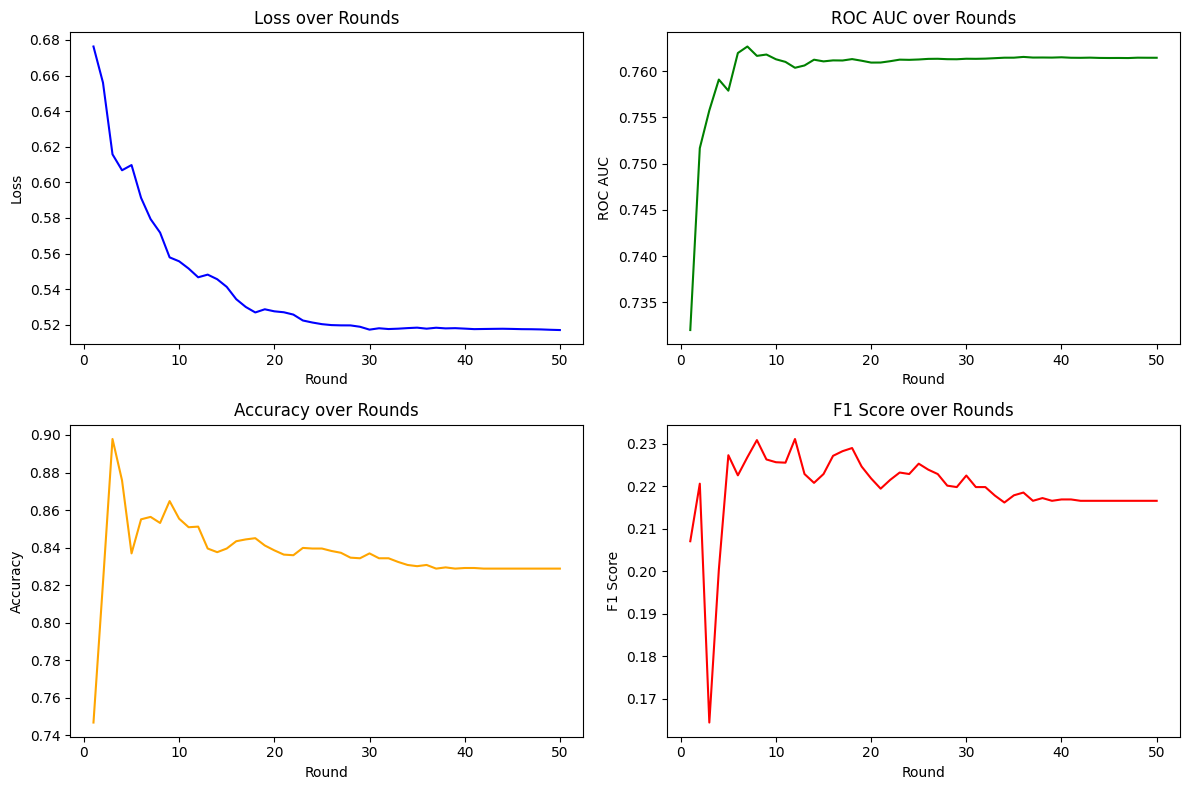

In [ ]:
L, ROC_AUC, ACCURACY, F1 = client.losses, client.ROC_AUCs, client.ACCURACYs, client.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [61]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self):

        super().__init__()
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
        print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_, y_train_)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train_), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        parameters[0] = dec_res[0]
        parameters[1]  = dec_res[1]
        print('parameters after eval MUST BE DECRYPTED!')
        print(parameters)
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier()
    model = LogisticRegression(
        penalty='l2',
        max_iter=5
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: get_parameters message b6c50ea1-ddbd-4201-afd3-29dafc44db21
INFO :      Sent reply


================== INITIAL PARAMS ==================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]


INFO :      
INFO :      Received: train message 7a3b9a9b-7d6a-4ac0-a150-d29cffe4fec5


============================ PARAMS BEFORE  FIT===========================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002618043FEB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000261808645B0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message ba322a0e-2cba-42e4-936d-8d41cb17678e


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x0000026180866DD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000261806C1210>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 258bb51b-c7fc-4d21-9be3-c1cae3d4809a


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x0000026180865030>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000261808857E0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 6d075249-e499-4262-92cd-00c648dab988


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x0000026180483A90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000026180886770>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 816e8706-4a27-4a15-bb4c-e365fe74a82b


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x0000026180865F90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000261808847F0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 01a87524-aa66-4322-81ba-06d9361a4d61


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x0000026180884820>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000026180885F60>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message b63352a8-6823-4167-b625-7527c01e8e0d
INFO :      Disconnect and shut down


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


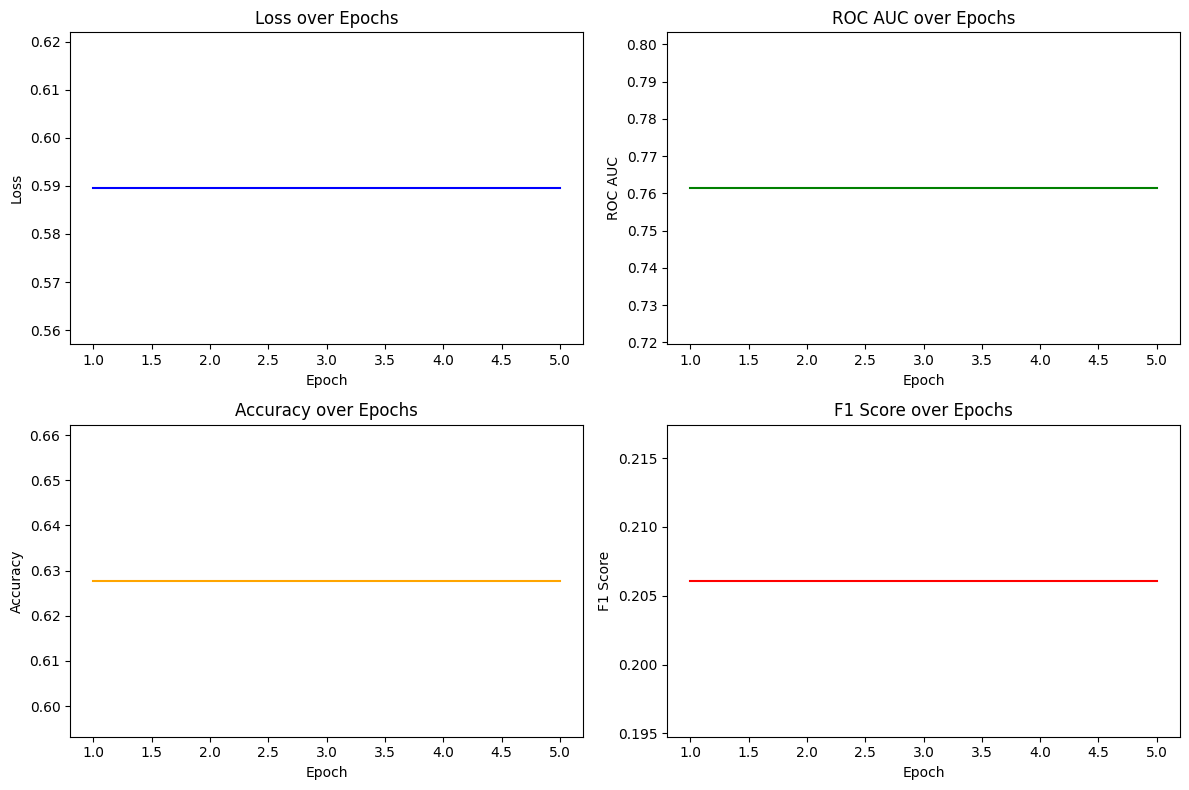

In [55]:
L, ROC_AUC, ACCURACY, F1 = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)